# Notebook for creating and loading tf record for model training


In [1]:
!pip install transformers #Installing Huggingface transformers 

     |████████████████████████████████| 1.3MB 6.0MB/s 
     |████████████████████████████████| 890kB 36.1MB/s 
     |████████████████████████████████| 1.1MB 35.4MB/s 
     |████████████████████████████████| 2.9MB 47.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fb5a0a50dc822f9db9862cf471743962bfeae6168399b886553968380b747047
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub
from collections import Counter
from transformers import TFBertModel, TFDistilBertModel
from keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, TFDistilBertForSequenceClassification

In [4]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Tue Nov 17 02:50:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    31W / 250W |    359MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

# we use the following to save the models
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

# save_model saves everything. weights, statuses and results. 
def save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results,path="/content/gdrive/My Drive/models"):
  model_name=model.name
  # Get the model train history
  model_train_history = training_results.history

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)
  # Save the enitire model (structure + weights)
  #model.save(os.path.join(path,model_name+".hdf5"))
  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  '''
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)
  '''
    
  #model_size = get_model_size(model_name=model_name)

  # Save model history
  with open(os.path.join(path,model_name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)
  total_params = trainable_parameters + non_trainable_parameters

  # Save model metrics
  metrics ={
      "total_params":total_params,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "learning_rate":learning_rate,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "name": model_name,
      "id": int(time.time())
  }

  with open(os.path.join(path,model.name+"_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_model(model,test_data, training_results,execution_time, learning_rate, epochs, 
                   optimizer,save=True, 
                   loss_metrics=["loss","val_loss"],
                   acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
      # Save model
      save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results
def get_dataset_size(base_path):
  dataset_folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size: ",dataset_folder_size)
  dataset_folder_size = dataset_folder_size.replace("G","000000000")
  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_download_size = dataset_download_size/1000000000
  dataset_size = dataset_folder_size - dataset_download_size

  print("Download Size: ",str(dataset_download_size)+"G")
  print("Dataset Size: ",str(dataset_size)+"G")

def get_dataset_list(base_path):
  # Labels
  label_names = os.listdir(base_path)

  # Generate a list of labels and path to images
  data_list = []
  for label in label_names:
      # Images
      image_files = os.listdir(os.path.join(base_path,label))
      data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

  return label_names, data_list

In [7]:
train_image="https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/train2014.zip"
train_question="https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip"
train_answer="https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip"
val_image="https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/val2014.zip"
val_question="https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip"
val_answer="https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip"
start_time = time.time()
download_file(train_image, base_path="images", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)
start_time = time.time()
download_file(val_image, base_path="images", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.7632917602856953
Download execution time (mins) 0.5464745799700419


In [8]:
start_time = time.time()
download_file(train_question, base_path="question_answer", extract=True)
download_file(train_answer, base_path="question_answer", extract=True)
download_file(val_question, base_path="question_answer", extract=True)
download_file(val_answer, base_path="question_answer", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.06951590379079182


#Preprocessing Data

In [9]:
# Read data from json file
with open('question_answer/v2_OpenEnded_mscoco_train2014_questions.json') as f:
  train_question=json.load(f)
train_data=pd.DataFrame.from_dict(train_question['questions'])
with open('question_answer/v2_mscoco_train2014_annotations.json') as f:
  train_answer=json.load(f)
train_answer=pd.DataFrame(train_answer['annotations'])
with open('question_answer/v2_OpenEnded_mscoco_val2014_questions.json') as f:
  val_question=json.load(f)
val_data=pd.DataFrame.from_dict(val_question['questions'])
with open('question_answer/v2_mscoco_val2014_annotations.json') as f:
  val_answer=json.load(f)
val_answer=pd.DataFrame(val_answer['annotations'])
#Merge question and answer
train_data=pd.merge(train_data,train_answer[['multiple_choice_answer','question_id']],how='left',on='question_id')
train_data.drop(columns=['question_id'],inplace=True)
val_data=pd.merge(val_data,val_answer[['multiple_choice_answer','question_id']],how='left',on='question_id')
val_data.drop(columns=['question_id'],inplace=True)
number_of_answer=10
counter=Counter(list(train_data.multiple_choice_answer.values)+list(val_data.multiple_choice_answer.values))
top10_answers=[]
for i in counter.most_common(number_of_answer):
  top10_answers.append(i[0])
label2index = dict((name, index) for index, name in enumerate(top10_answers))
index2label = dict((index, name) for index, name in enumerate(top10_answers))
train_data=train_data[train_data.multiple_choice_answer.isin(top10_answers)]
val_data=val_data[val_data.multiple_choice_answer.isin(top10_answers)]

In [10]:
#Build dataset
train_image=train_data.image_id.values
train_question=train_data.question.values
train_y=train_data.multiple_choice_answer.values
val_image=val_data.image_id.values
val_question=val_data.question.values
val_y=val_data.multiple_choice_answer.values
train_image=['images/train2014/COCO_train2014_'+'0'*(12-len(str(i)))+str(i)+'.jpg' for i in train_image]
val_image=[f'images/val2014/COCO_val2014_'+'0'*(12-len(str(i)))+str(i)+'.jpg' for i in val_image]
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_width = 224
image_height = 224
num_channels = 3
num_classes = len(top10_answers) 
batch_size = 32
shuffle_buffer_size=3000 # For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
train_processed_y = [label2index[label] for label in train_y]
val_processed_y = [label2index[label] for label in val_y]


In [11]:
# Preprocess Bert encoding
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
max_length=max(len(max(train_question,key=len)),len(max(val_question,key=len)))
train_x=tokenizer.batch_encode_plus(
        train_question,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=max_length, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )
validate_x=tokenizer.batch_encode_plus(
        val_question,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=max_length, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )
num_vocab = tokenizer.vocab_size

#Save data to TF record

In [12]:
# Helper function
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def serialize_example(feature0, feature1, feature2, feature3,feature4):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _bytes_feature(feature0),
      'feature1': _bytes_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _bytes_feature(feature3),
      'feature4': _int64_feature(feature4),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()
def load_normalize_train_image_tfrecord(path,input_id,token_type_ids,attention_mask,label):
  image = tf.io.read_file(path)
  #image=open(path,'rb').read()
  return image,input_id,token_type_ids,attention_mask,label
def tf_serialize_example(f0,f1,f2,f3,f4):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3,f4),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar
#built desired input format
def serialize_tensor(feature_0,feature_1,feature_2,feature_3,feature_4):
  return feature_0,tf.io.serialize_tensor(feature_1),tf.io.serialize_tensor(feature_2),tf.io.serialize_tensor(feature_3),feature_4
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature1': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature4': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)
def parse_data_set(dictionary):
  image = tf.image.decode_jpeg(dictionary['feature0'], channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  #normlize pixel
  image = image/255
  input_ids=tf.ensure_shape(tf.io.parse_tensor(dictionary['feature1'], tf.int32, name=None),[100])
  token_type_ids=tf.ensure_shape(tf.io.parse_tensor(dictionary['feature2'], tf.int32, name=None),[100])
  attention_mask=tf.ensure_shape(tf.io.parse_tensor(dictionary['feature3'], tf.int32, name=None),[100])
  label=dictionary['feature4']
  return image,input_ids,token_type_ids,attention_mask,label
def processing_tf_record_input(image,input_ids,token_type_ids,attention_mask,label):
  return ((image,{'input_ids':input_ids,
          'token_type_ids':token_type_ids,
            'attention_mask':attention_mask}),label)

In [13]:
#Save train_record
train_record=tf.data.Dataset.from_tensor_slices((train_image,train_x['input_ids'],train_x['token_type_ids'],train_x['attention_mask'],train_processed_y))
train_record=train_record.map(load_normalize_train_image_tfrecord, num_parallel_calls=AUTOTUNE)
train_record=train_record.map(serialize_tensor,num_parallel_calls=AUTOTUNE)
train_record=train_record.map(tf_serialize_example)
filename='train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(train_record)

In [14]:
#Save validation_record
validation_record=tf.data.Dataset.from_tensor_slices((val_image,validate_x['input_ids'],validate_x['token_type_ids'],validate_x['attention_mask'],val_processed_y))
validation_record=validation_record.map(load_normalize_train_image_tfrecord, num_parallel_calls=AUTOTUNE)
validation_record=validation_record.map(serialize_tensor,num_parallel_calls=AUTOTUNE)
validation_record=validation_record.map(tf_serialize_example)
filename='validation.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(validation_record)

# Read data from tf record

In [15]:
#Reading train_data from tf_record
batch_size = 64 # You can try higher values but may run into OOM errors depending on which GPU you are using
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200
filenames = 'train.tfrecord'
train_raw_dataset = tf.data.TFRecordDataset(filenames)
train_parsed_dataset = train_raw_dataset.map(_parse_function,num_parallel_calls=AUTOTUNE)
train_parsed_dataset = train_parsed_dataset.map(parse_data_set,num_parallel_calls=AUTOTUNE)
train_data=train_parsed_dataset.map(processing_tf_record_input, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
print(train_data)

<BatchDataset shapes: (((None, 224, 224, 3), {input_ids: (None, 100), token_type_ids: (None, 100), attention_mask: (None, 100)}), (None,)), types: ((tf.float32, {input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}), tf.int64)>


In [16]:
#Reading validation data from tf_record
filenames = 'validation.tfrecord'
validation_raw_dataset = tf.data.TFRecordDataset(filenames)
validation_parsed_dataset = validation_raw_dataset.map(_parse_function,num_parallel_calls=AUTOTUNE)
validation_parsed_dataset = validation_parsed_dataset.map(parse_data_set,num_parallel_calls=AUTOTUNE)
validation_data=validation_parsed_dataset.map(processing_tf_record_input, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=train_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
print(validation_data)

<BatchDataset shapes: (((None, 224, 224, 3), {input_ids: (None, 100), token_type_ids: (None, 100), attention_mask: (None, 100)}), (None,)), types: ((tf.float32, {input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}), tf.int64)>


### Visual Question Answering Model

In [ ]:

K.clear_session()
learning_rate=0.001
## QA Model
max_len = 100
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
image_input = layers.Input(shape=[224,224,3], name='image_input')

#question model: BERT
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
text_dropout=layers.Dropout(0.2)(embedding_flatten)
bert_dense = layers.Dense(256, name="bert_dense")(text_dropout)


#image model: mobilenet
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet')
mobilenetv2.trainable=False
image_flat = layers.Flatten()(mobilenetv2(image_input))
image_dropout=layers.Dropout(0.2)(image_flat)
#image_flat = Flatten()(model.layers[-1].output)(image_pretrained)
image_dense = layers.Dense(256, activation='relu')(image_dropout)

#image + question
image_question = layers.Multiply()([bert_dense, image_dense])                          
image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

model = keras.Model(inputs= inputs, outputs= classifier,name='Vqa_model_dropout')

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.SparseCategoricalAccuracy()])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "Vqa_model_dropout"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________

#Training using data from TF record

Epoch 1/10
3569/3569 [==============================] - 1565s 438ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.4225 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.4501
Epoch 2/10
3569/3569 [==============================] - 1561s 437ms/step - loss: 1.0619 - sparse_categorical_accuracy: 0.4380 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.4623
Epoch 3/10
3569/3569 [==============================] - 1560s 437ms/step - loss: 1.0534 - sparse_categorical_accuracy: 0.4376 - val_loss: 0.9145 - val_sparse_categorical_accuracy: 0.4576
Epoch 4/10
3569/3569 [==============================] - 1558s 437ms/step - loss: 1.0384 - sparse_categorical_accuracy: 0.4375 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.4536
Epoch 5/10
3569/3569 [==============================] - 1552s 435ms/step - loss: 1.0326 - sparse_categorical_accuracy: 0.4388 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.4526
Epoch 6/10
3569/3569 [==============================] - 1548s 434

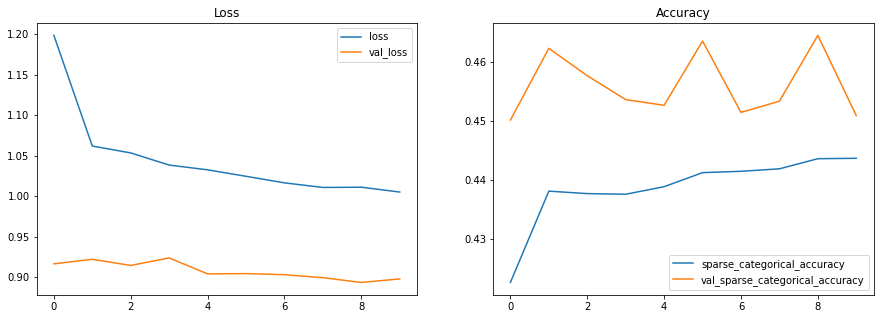

1721/1721 [==============================] - 561s 326ms/step - loss: 0.8969 - sparse_categorical_accuracy: 0.4532
{'loss': 0.8969497084617615, 'sparse_categorical_accuracy': 0.45315423607826233}


[0.8969497084617615, 0.45315423607826233]

In [ ]:
#Training use TF record
epochs=10
start_time = time.time()
training_results=model.fit( train_data, validation_data = validation_data.take(1000), epochs=epochs, verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
evaluate_model(model,validation_data, training_results,execution_time, 
               learning_rate, epochs, optimizer,save=False,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])